In [ ]:
# Install gradio and fetching dataset
!pip install gradio

!gdown 1RP0UJuYrHoBd2OaTDc2BSYp0ylbcP7yh
!unzip -q Dataset.zip

!gdown 1A4qUeU5AXP6NPY2WKkLyyEFNsC8eTmCd
!unzip -q archive.zip

!ls

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing in

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gradio as gr
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

In [ ]:
# Define global variables and process the dataset
image_size = (180, 180)
batch_size = 32
input_shape = (180, 180, 3)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-8)

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "Lung Dataset CT 2",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/archive/Data",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

Found 977 files belonging to 2 classes.
Using 782 files for training.
Using 195 files for validation.
Found 781 files belonging to 2 classes.


In [ ]:
#########################   Model Creation   #########################
# Define the CNN from scratch functions
def cnn_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    """A convolutional block."""
    bn_axis = 3  # For 'channels_last' format
    if conv_shortcut:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(input_tensor)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='SAME', name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def cnn_model(input_shape, classes=1):
    img_input = layers.Input(shape=input_shape)
    bn_axis = 3  # For 'channels_last' format

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, name='conv1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = cnn_block(x, 64, stride=1, conv_shortcut=True, name='conv2_block1')
    x = cnn_block(x, 64, conv_shortcut=False, name='conv2_block2')

    x = cnn_block(x, 128, stride=2, conv_shortcut=True, name='conv3_block1')
    x = cnn_block(x, 128, conv_shortcut=False, name='conv3_block2')

    x = cnn_block(x, 256, stride=2, conv_shortcut=True, name='conv4_block1')
    x = cnn_block(x, 256, conv_shortcut=False, name='conv4_block2')

    x = cnn_block(x, 512, stride=2, conv_shortcut=True, name='conv5_block1')
    x = cnn_block(x, 512, conv_shortcut=False, name='conv5_block2')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='sigmoid', name='probs')(x)

    model = models.Model(img_input, x, name='cnn_model')
    return model

#########################   Testing Helper Functions   #########################
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend(loc='lower right')
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend(loc='upper right')
    plt.show()


#########################   Gradio Interface   #########################

# Define the image preprocessing function for gradio interface
def preprocess_image(image):
    image = image.resize((180, 180))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)  # add batch dimension
    return image

# Define the prediction function for CNN model gradio interface
def predict_cnn(image):
    image = preprocess_image(image)
    prediction = CNN.predict(image)[0][0]
    if prediction < 0.5:
        return f"Prediction: Lung Cancer Detected (Confidence: {prediction:.2f})"
    else:
        return f"Prediction: No Lung Cancer Detected (Confidence: {prediction:.2f})"

########################################################

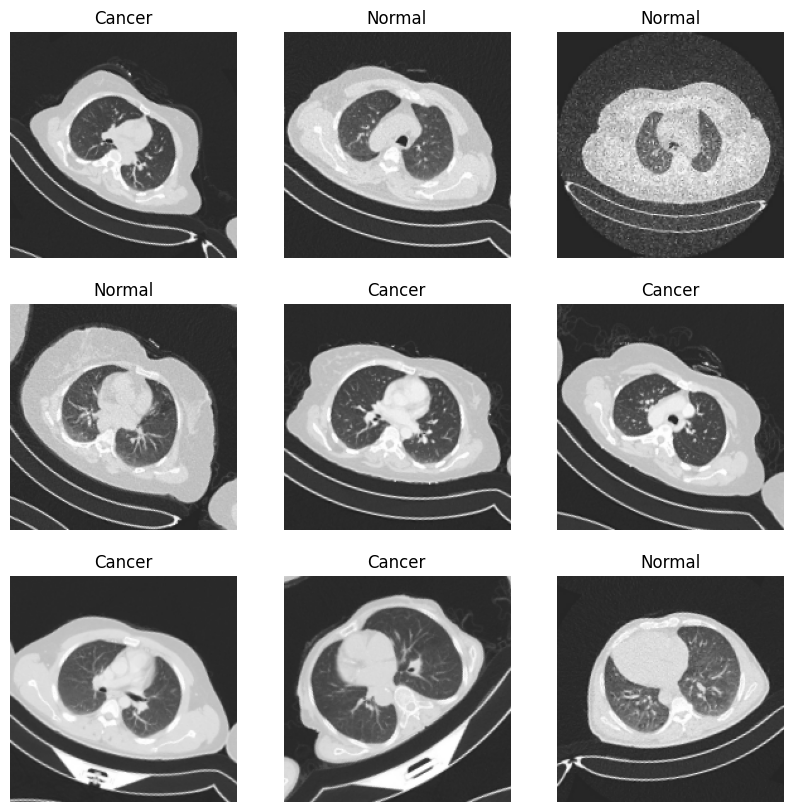

In [ ]:
# Label mapping
label_map = {0: "Cancer", 1: "Normal"}

# Example data
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_map[int(labels[i])])
        plt.axis("off")
    plt.show()

In [ ]:
# Load CNN Model
CNN = load_model('CNN.keras')

ValueError: File not found: filepath=CNN.keras. Please ensure the file is an accessible `.keras` zip file.

Epoch 1/45
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5889 - loss: 0.6911 - val_accuracy: 0.5385 - val_loss: 0.6886 - learning_rate: 1.0000e-06
Epoch 2/45
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.5830 - loss: 0.6778 - val_accuracy: 0.5385 - val_loss: 0.6896 - learning_rate: 1.0000e-06
Epoch 3/45
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.5995 - loss: 0.6644 - val_accuracy: 0.5385 - val_loss: 0.6904 - learning_rate: 1.0000e-06
Epoch 4/45
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.6007 - loss: 0.6544 - val_accuracy: 0.5385 - val_loss: 0.6906 - learning_rate: 1.0000e-06
Epoch 5/45
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.5989 - loss: 0.6521 - val_accuracy: 0.5385 - val_loss: 0.6882 - learning_rate: 1.0000e-06
Epoch 6/45
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.6541 - loss: 0.6309 - val_accuracy: 0.5385 - val_loss: 0.6841 - learning_rate: 1.0000e-06
Epoch 7/45
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy:

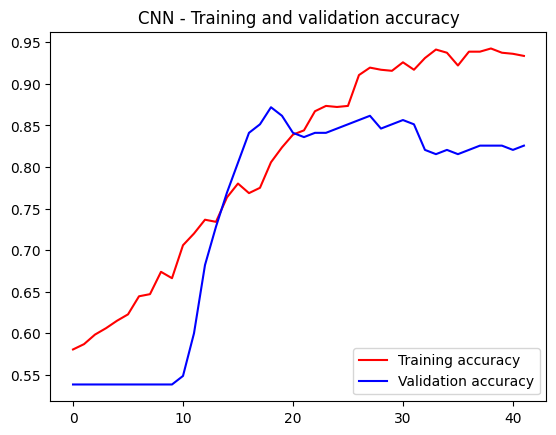

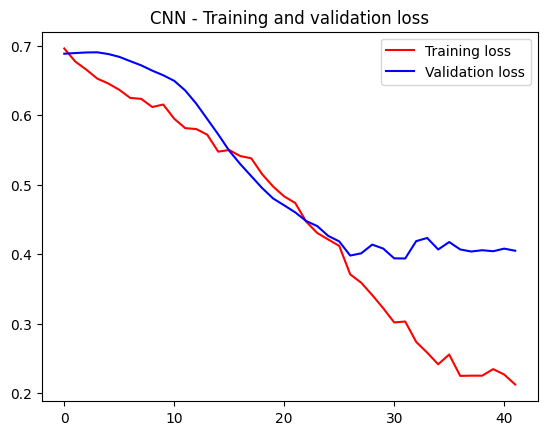

In [ ]:
###################################    CNN    ###################################

# Create new CNN
CNN = cnn_model(input_shape)
CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
history_CNN = CNN.fit(train_ds, validation_data=val_ds, epochs=45, callbacks=[early_stopping, reduce_lr])

# Plot Data
plot_history(history_CNN, 'CNN')

In [ ]:
# Save CNN Model
CNN.save('CNN.keras')

In [ ]:
# Evaluate accuracy for CNN model
val_loss_CNN, val_acc_CNN = CNN.evaluate(test_ds)
print(f"Accuracy (CNN): {val_acc_CNN:.4f}")

y_pred_probs = CNN.predict(test_ds)
y_pred_classes = (y_pred_probs > 0.5).astype(int)  # Assuming binary classification

# Extract true labels from the test dataset
y_test = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classes).ravel()

# Calculate AUC and AUROC
auc = roc_auc_score(y_test, y_pred_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
auroc = auc  # In most cases, AUROC and AUC are the same

# Compile the results
results = {
    'True Positives': tp,
    'True Negatives': tn,
    'AUC': auc,
    'AUROC': auroc
}

print("CNN Model Results:", results)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.7528 - loss: 0.6251
Accuracy (CNN): 0.7439
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step
CNN Model Results: {'True Positives': 33, 'True Negatives': 512, 'AUC': 0.4914102564102564, 'AUROC': 0.4914102564102564}


In [ ]:
###################################    Gradio    ###################################

# Create Gradio interface for the CNN model
image_input = gr.Image(type="pil")
output_text = gr.Textbox()

interface_CNN = gr.Interface(fn=predict_cnn, inputs=image_input, outputs=output_text, title="Lung Cancer Detection - CNN Model", description="Upload a CT scan image to predict lung cancer using the CNN model")

# Launch the CNN model interface
interface_CNN.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cb5c36617f1723d83b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
